In [1]:
# Config Variables

# Define UCI Datasets to pull
# https://archive.ics.uci.edu/ml/datasets.php
uci_datasets = [165]

# Training set sizes to use (only training set sizes < 60% of total dataset size will be used)
training_set_sizes = [10, 40, 160, 610, 2560, 10240, 40960]

In [2]:
# Load necessary libraries and helper functions

# import helper functions from helpers/data_manipulation.py
from helpers.data_manipulation import *

# import half_ridge functions from helpers/half_ridge.py
from helpers.half_ridge import *

# import dataset class
from helpers.model import Model

# import os and pickle
import os
import pickle
 
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)

# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import FuncFormatter
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns
import time

from IPython.core.pylabtools import figsize

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

# PyMC3 for Bayesian Inference
import arviz as az
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Graphed Values
Training Set Size: 10
[0.4628, 0.4622, 0.47540000000000004, 0.4654, 0.46579999999999994, 0.4746, 0.46959999999999996, 0.47939999999999994, 0.4728, 0.5227999999999999, 0.647, 0.6372, 0.6144000000000001, 0.6086, 0.6026, 0.6184, 0.6104, 0.6215999999999999, 0.6078000000000001, 0.6208, 0.6176, 0.4726]
[0.008501294019147905, 0.011075739252979909, 0.01239548304827206, 0.006174787445734462, 0.004753104248804138, 0.003822041339389194, 0.005963891347098799, 0.003256992477731568, 0.010614706778804585, 0.015182621644498684, 0.01967943088608002, 0.024303744567452972, 0.02854554255921578, 0.027003110931890777, 0.024982553912680748, 0.023651807541919503, 0.024546445771231332, 0.03290908689100929, 0.02194793839976775, 0.02247914589124776, 0.022679682537460725, 0.0036287738976133453]
Graphed Values
Training Set Size: 40
[0.46579999999999994, 0.462, 0.4664, 0.48979999999999996, 0.4624, 0.4796, 0.4478, 0.4766, 0.4718, 0.6086, 0.6122, 0.5974, 0.599, 0.6094, 0.599, 0.6060000000000001, 0.61, 

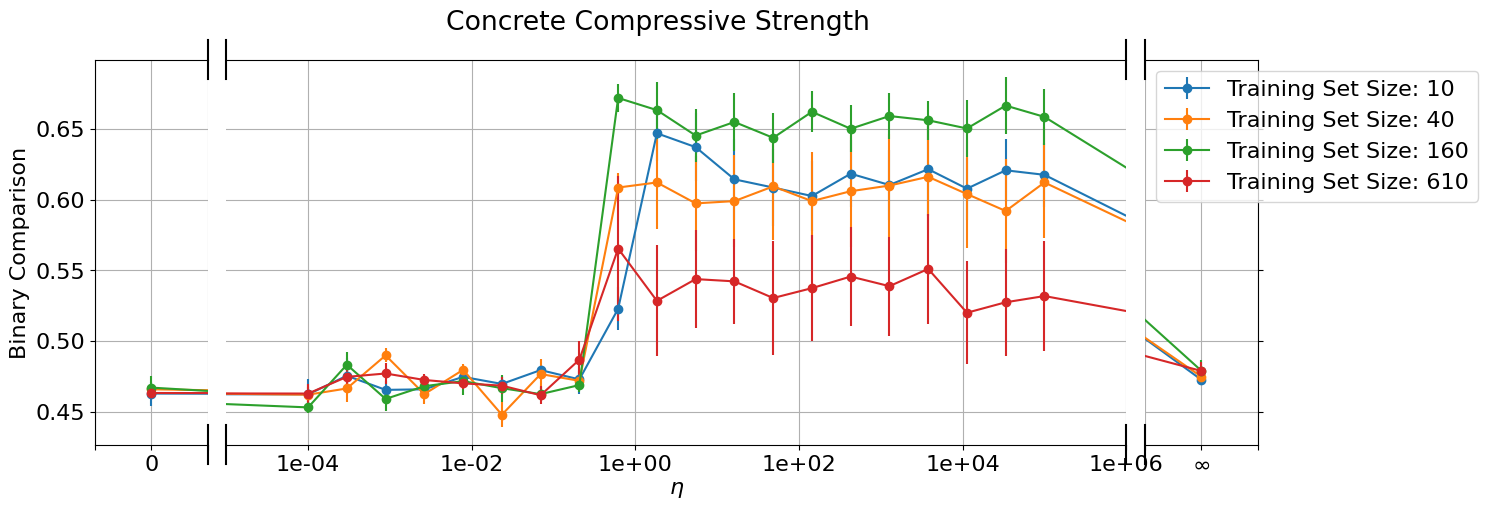

Cross-validation sses: [0.46320000000000006, 0.4628, 0.4746, 0.47700000000000004, 0.47240000000000004, 0.4699999999999999, 0.4683999999999999, 0.46160000000000007, 0.4868, 0.5654, 0.5284, 0.5438, 0.5421999999999999, 0.5304, 0.5374, 0.5456, 0.5388000000000001, 0.551, 0.52, 0.5274, 0.5318, 0.4788]
Mean sse: 0.5080818181818182


In [4]:
very_high_number = 10  # Replace this with an appropriate value for infinity
very_low_number = -10  # Replace this with an appropriate value for 0

# Function to format the tick labels
def sci_notation(tick_val, pos):
    if tick_val == very_low_number:
        return r''
    elif tick_val == very_high_number:
        return r''
    else:
        return f"{10**tick_val:.0e}"
def inf_zero_formatter(tick_val, pos):
    if tick_val == very_low_number:
        return r'$0$'
    elif tick_val == very_high_number:
        return r'$\infty$'
    else:
        return f''

# Create a loop that iterates over datasets
for p_index, dataset in enumerate(uci_datasets):

    model = Model()
    model.import_from_file('uci_ml_datasets/ucirepo_' + str(dataset) + '.csv')
    model.format_data()
    training_set_values = model.set_up_training_values(training_set_sizes, .6)

    with open('model_results/ucirepo_' + str(dataset) + '.csv', 'rb') as file:
        binary_comparisons = pickle.load(file)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 5), gridspec_kw={'width_ratios': [.1, .8, .1]})
    fig.suptitle(f'Concrete Compressive Strength')
    plt.subplots_adjust(wspace=0.05)


    # Loop over all_results and print a scatter plot with lambda (1/(eta ** 4)) on the x-axis and the mean binary_comparisons on the y-axis for each training set size
    for training_set_value in training_set_values:
    
        etas = list(binary_comparisons[training_set_value].keys())
        binary_comparison_means = [np.mean(binary_comparisons[training_set_value][eta]) for eta in etas]
        binary_comparison_se = [np.std(binary_comparisons[training_set_value][eta]) / np.sqrt(len(binary_comparisons[training_set_value][eta])) for eta in etas]

        print('Graphed Values')
        print(f"Training Set Size: {training_set_value}")
        print(binary_comparison_means)
        print(binary_comparison_se)

        # Separate etas and their corresponding means and errors
        normal_etas = [eta for eta in etas if eta != 0 and eta != np.inf]
        log_normal_etas = np.log10(normal_etas)
        normal_means = [binary_comparison_means[i] for i, eta in enumerate(etas) if eta != 0 and eta != np.inf]
        normal_se = [binary_comparison_se[i] for i, eta in enumerate(etas) if eta != 0 and eta != np.inf]

        # Insert eta=0 and eta=np.inf into the lists with their positions
        if 0 in etas:
            zero_idx = etas.index(0)
            log_normal_etas = np.insert(log_normal_etas, 0, very_low_number)
            normal_means.insert(0, binary_comparison_means[zero_idx])
            normal_se.insert(0, binary_comparison_se[zero_idx])
        if np.inf in etas:
            inf_idx = etas.index(np.inf)
            log_normal_etas = np.append(log_normal_etas, very_high_number)
            normal_means.append(binary_comparison_means[inf_idx])
            normal_se.append(binary_comparison_se[inf_idx])

        # Plot the results for normal etas including eta=0 and eta=inf
        ax1.errorbar(log_normal_etas, normal_means, yerr=normal_se, fmt='o-', label=f"Training Set Size: {training_set_value}")
        ax2.errorbar(log_normal_etas, normal_means, yerr=normal_se, fmt='o-', label=f"Training Set Size: {training_set_value}")
        ax3.errorbar(log_normal_etas, normal_means, yerr=normal_se, fmt='o-', label=f"Training Set Size: {training_set_value}")

    # Set axis limits and labels
    ax1.set_xlim(left=very_low_number-1, right=very_low_number+1)  # Adjust as needed to create space around 0
    ax2.set_xlim(left=log_normal_etas[1]-1, right=log_normal_etas[-2]+1)  # Adjust as needed to create space around infinity
    ax3.set_xlim(left=very_high_number-1, right=very_high_number+1)  # Adjust as needed to create space around infinity
    ax2.set_xlabel(r'$\eta$')
    ax1.set_ylabel('Binary Comparison')
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    ax3.legend()
    
    # Use the custom formatter for the x-axis
    ax1.xaxis.set_major_formatter(FuncFormatter(inf_zero_formatter))
    ax2.xaxis.set_major_formatter(FuncFormatter(sci_notation))
    ax3.xaxis.set_major_formatter(FuncFormatter(inf_zero_formatter))

    # Hide the right spines of ax1 and the left spines of ax2
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax1.yaxis.tick_left()
    ax2.tick_params(left = False) 
    ax3.yaxis.tick_right()

    
    # Draw small vertical lines to indicate the break
    line_length = 0.05  # Length of the vertical lines

    # Top and bottom lines at the right edge of ax1
    ax1.plot([1, 1], [1 - line_length, 1 + line_length], transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot([1, 1], [0 - line_length, line_length], transform=ax1.transAxes, color='k', clip_on=False)

    # Top and bottom lines at the left edge of ax2
    ax2.plot([0, 0], [1 - line_length, 1 + line_length], transform=ax2.transAxes, color='k', clip_on=False)
    ax2.plot([0, 0], [0 - line_length, line_length], transform=ax2.transAxes, color='k', clip_on=False)

    # Top and bottom lines at the right edge of ax2
    ax2.plot([1, 1], [1 - line_length, 1 + line_length], transform=ax2.transAxes, color='k', clip_on=False)
    ax2.plot([1, 1], [0 - line_length, line_length], transform=ax2.transAxes, color='k', clip_on=False)

    # Top and bottom lines at the left edge of ax3
    ax3.plot([0, 0], [1 - line_length, 1 + line_length], transform=ax3.transAxes, color='k', clip_on=False)
    ax3.plot([0, 0], [0 - line_length, line_length], transform=ax3.transAxes, color='k', clip_on=False)

    plt.show()

    print("Cross-validation sses:", binary_comparison_means)
    print("Mean sse:", np.mean(binary_comparison_means))